# Concrete solutions to real problems
## An NLP workshop by Emmanuel Ameisen [(@EmmanuelAmeisen)](https://twitter.com/EmmanuelAmeisen), from Insight AI

*References:

[https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/learning-stack/Colab-ML-Playbook/blob/master/How%20to%20solve%20NLP%20problems/NLP_notebook.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/learning-stack/Colab-ML-Playbook/blob/master/How%20to%20solve%20NLP%20problems/NLP_notebook.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

While there exist a wealth of elaborate and abstract NLP techniques, clustering and classification should always be in our toolkit as the first techniques to use when dealing with this kind of data. In addition to being amongst some of the easiest to scale in production, their ease of use can quickly help business address a set of applied problems:

- How do you automatically make the distinction between different categories of sentences?
- How can you find sentences in a dataset that are most similar to a given one?
- How can you extract a rich and concise representation that can then be used for a range of other tasks?
- Most importantly, how do you find quickly whether these tasks are possible on your dataset at all?

While there is a vast amount of resources on classical Machine Learning, or Deep Learning applied to images, I've found that there is a lack of clear, simple guides as to what to do when one wants to find a meaningful representation for sentences (in order to classify them or group them together for examples). Here is my attempt below.

## It starts with data

### Our Dataset: Disasters on social media
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous). Thank you [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

### Why it matters
We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:
- It is actionable to anybody trying to get signal from noise (such as police departments in this case)
- It is tricky because relying on keywords is harder than in most cases like spam

In [37]:
! pip3 install gensim

    100% |████████████████████████████████| 23.5MB 1.5MB/s 
    100% |████████████████████████████████| 1.4MB 11.9MB/s 
    100% |████████████████████████████████| 133kB 22.6MB/s 
    100% |████████████████████████████████| 61kB 20.1MB/s 
    100% |████████████████████████████████| 4.6MB 7.4MB/s 
    100% |████████████████████████████████| 552kB 20.7MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [2]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

Using TensorFlow backend.


### Sanitizing input
Let's make sure our tweets only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [3]:
!wget https://raw.githubusercontent.com/hundredblocks/concrete_NLP_tutorial/master/socialmedia_relevant_cols.csv

--2018-08-29 20:33:47--  https://raw.githubusercontent.com/hundredblocks/concrete_NLP_tutorial/master/socialmedia_relevant_cols.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1270924 (1.2M) [text/plain]
Saving to: ‘socialmedia_relevant_cols.csv’

socialmedia_relevan 100%[===================>]   1.21M  --.-KB/s    in 0.1s    

2018-08-29 20:33:47 (9.55 MB/s) - ‘socialmedia_relevant_cols.csv’ saved [1270924/1270924]



In [0]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

### Let's inspect the data
It looks solid, but we don't really need urls, and we would like to have our words all lowercase (Hello and HELLO are pretty similar for our task)

In [5]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [6]:
questions.tail()

,text,choose_one,class_label
10854,1.3 #Earthquake in 9Km Ssw Of Anza California ...,Relevant,1
10855,Evacuation order lifted for town of Roosevelt:...,Relevant,1
10856,See the 16yr old PKK suicide bomber who detona...,Relevant,1
10857,To conference attendees! The blue line from th...,Relevant,1
10858,The death toll in a #IS-suicide car bombing on...,Relevant,1


In [7]:
questions.describe()

,class_label
count,10859.000000
mean,0.431808
std,0.498317
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


Let's use a few regular expressions to clean up pour data, and save it back to disk for future use

In [8]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [9]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10854,10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1
10855,10855,evacuation order lifted for town of roosevelt,Relevant,1
10856,10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1
10857,10857,to conference attendees! the blue line from th...,Relevant,1
10858,10858,the death toll in a is suicide car bombing on...,Relevant,1


### Data Overview

Let's look at our class balance.

In [11]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6186,6186,6186
1,4657,4657,4657
2,16,16,16


We can see our classes are pretty balanced, with a slight oversampling of the "Irrelevant" class.

### Our data is clean, now it needs to be prepared
Now that our inputs are more reasonable, let's transform our inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Creating a train test split
- Inspecting our data a little more to validate results

In [12]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


### Inspecting our dataset a little more

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154484 words total, with a vocabulary size of 18095
Max sentence length is 34


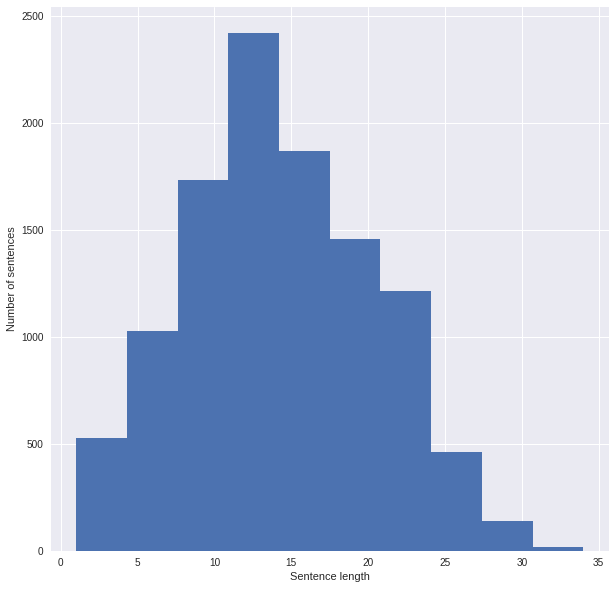

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## On to the Machine Learning
Now that our data is clean and prepared, let's dive in to the machine learning part.

## Enter embeddings
 Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?
 
A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

## Bag of Words Counts

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings
Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 20k dimensions is hard, let's project it down to 2.

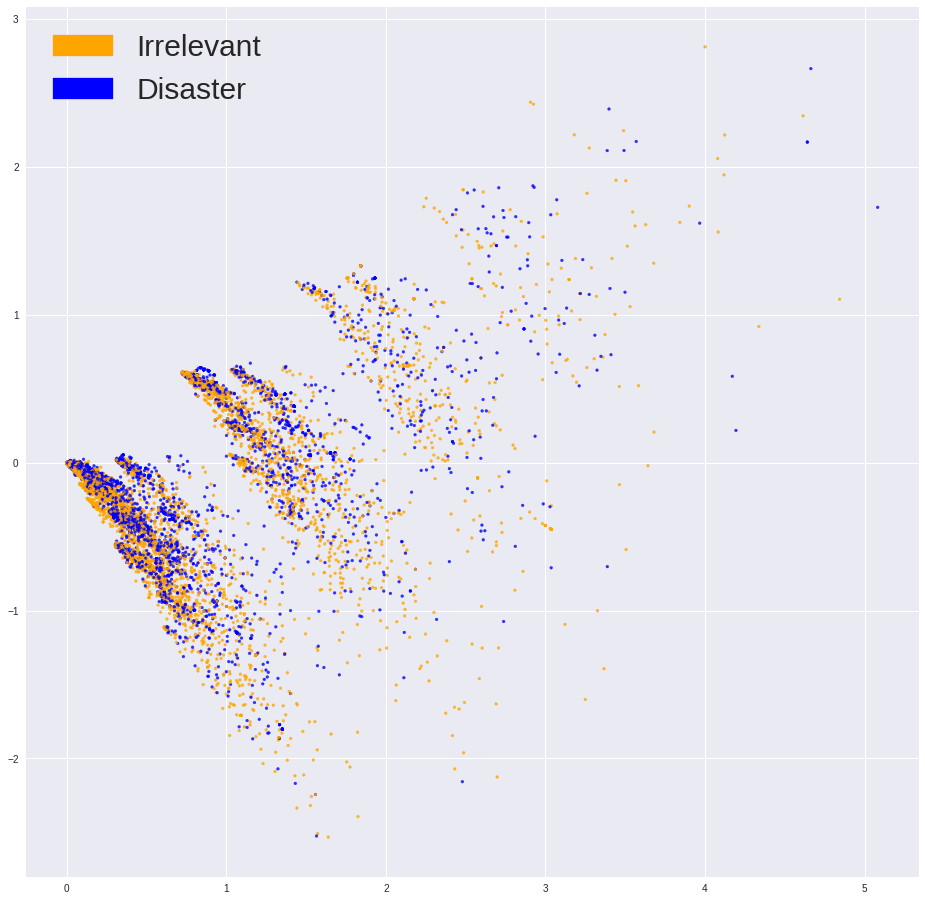

In [16]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

### Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### Evaluation
Let's start by looking at some metrics to see if our classifier performed well at all.

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.758, recall = 0.761, f1 = 0.759


### Inspection
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

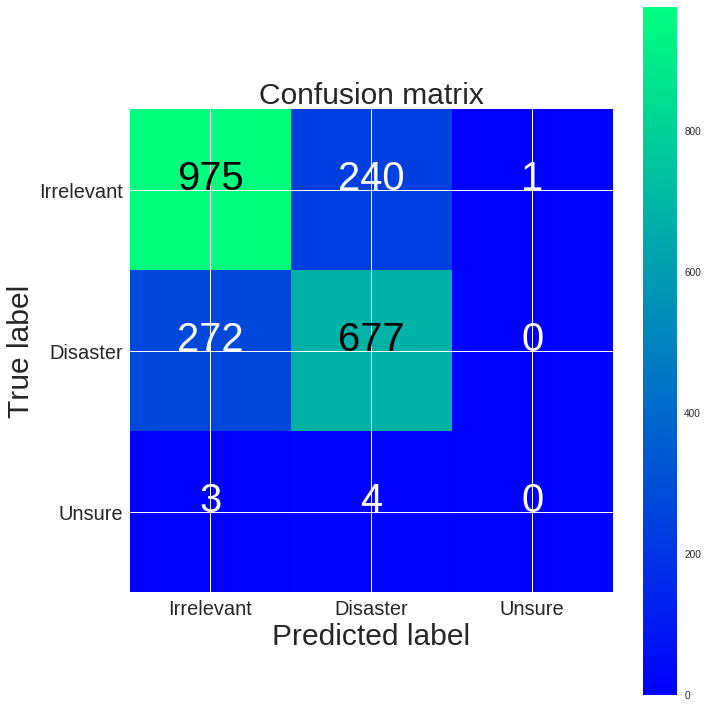

[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [24]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Our classifier never predicts class 3, which is not surprising, seeing as it is critically undersampled. This is not very important here, as the label is not very meaningful. Our classifier creates more false negatives than false positives (proportionally). Depending on the use case, this seems desirable (a false positive is quite a high cost for law enforcement for example).

### Further inspection
Let's look at the features our classifier is using to make decisions.

In [0]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

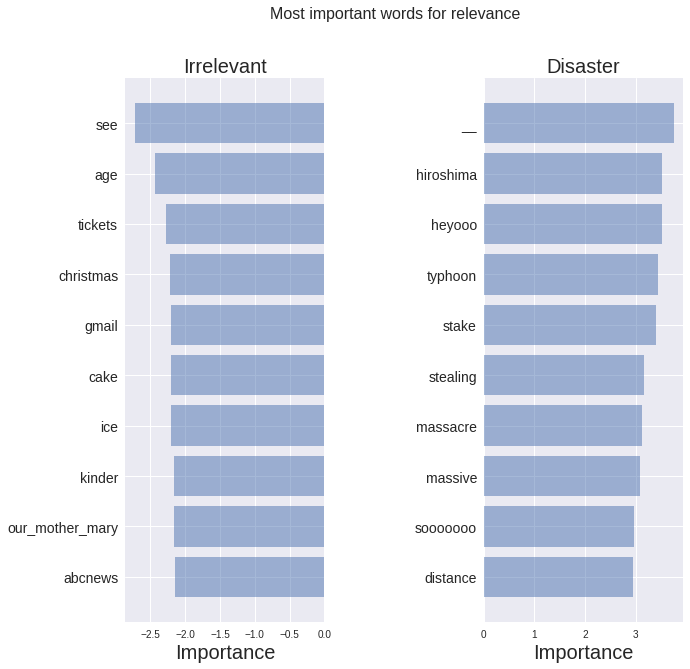

In [26]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Our classifier correctly picks up on some patterns (hiroshima, massacre), but clearly seems to be overfitting on some irellevant terms (heyoo, x1392)

### TFIDF Bag of Words
Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

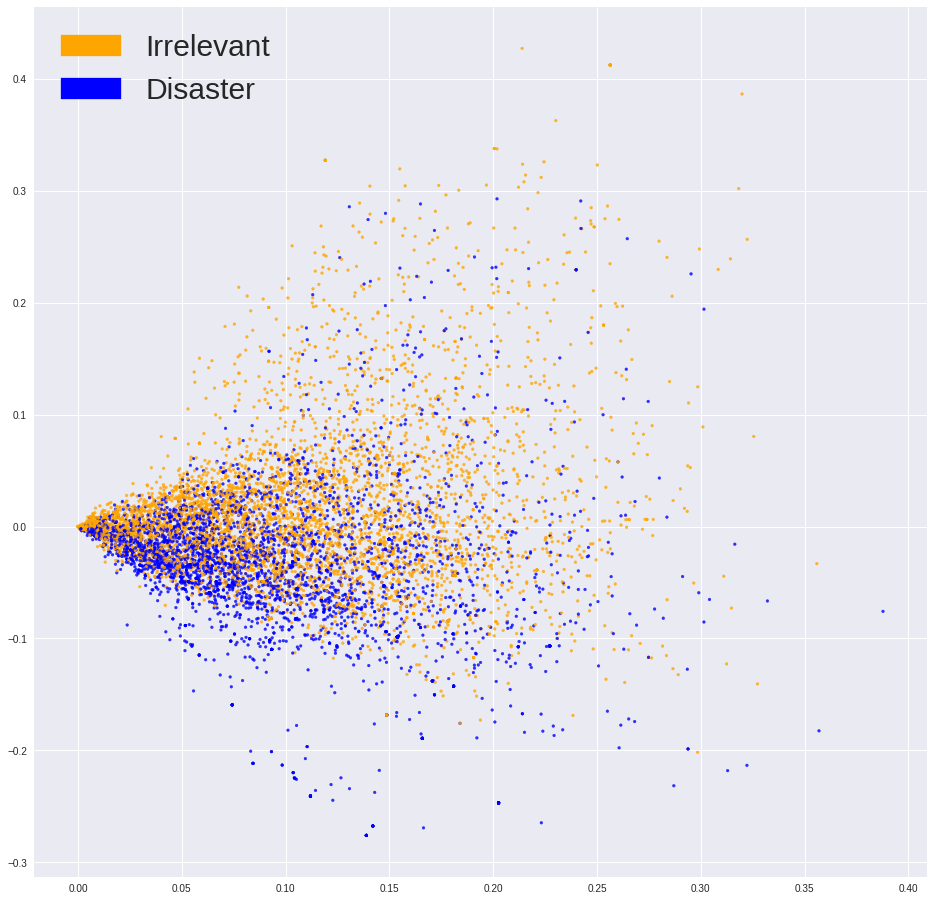

In [28]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

In [0]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [30]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.760, precision = 0.757, recall = 0.760, f1 = 0.758


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The results are a little better, let's see if they translate to an actual difference in our use case.

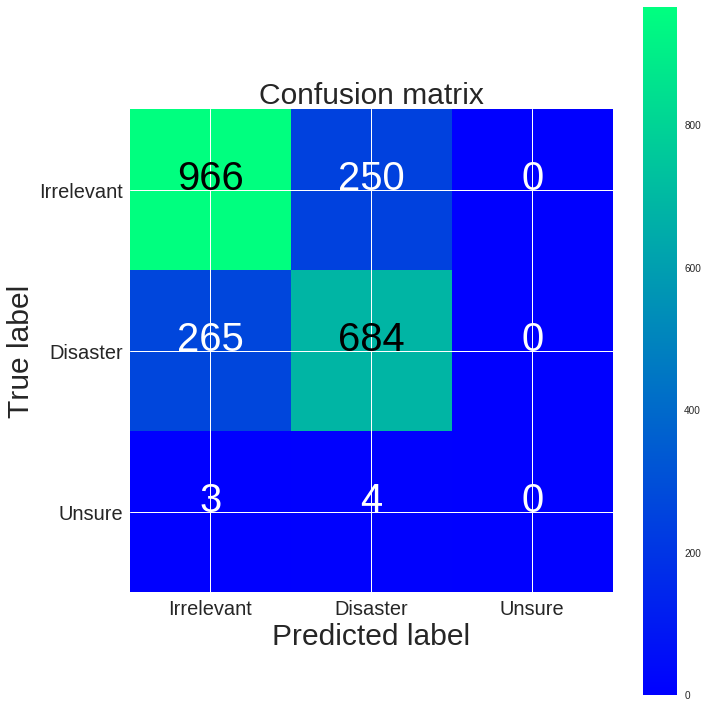

TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [31]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Our False positives have decreased, as this model is more conservative about choosing the positive class.

# Looking at important coefficients for linear regression
Insert details here

In [0]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

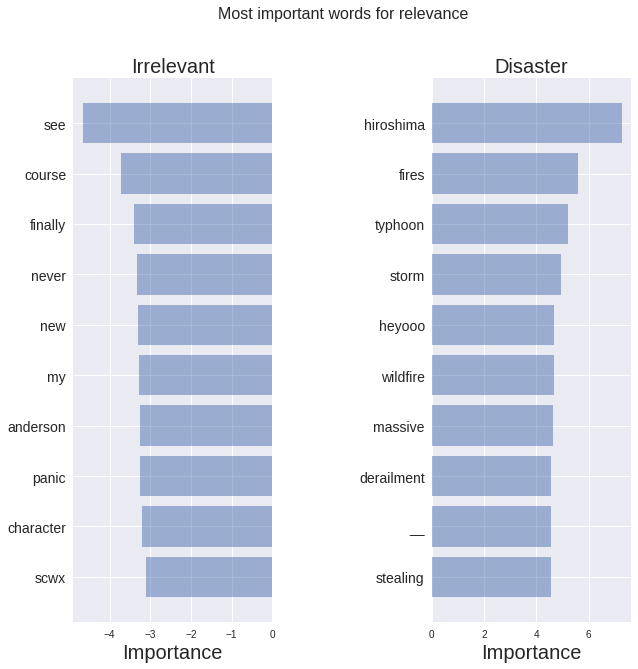

In [33]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The words it picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.

### Capturing semantic meaning
Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. Meaning we need to understand that words like 'good' and 'positive' are closer than apricot and 'continent'.

### Enter word2vec
Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [35]:
!wget https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz

--2018-08-29 20:52:21--  https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz?raw=true
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/eyaler/word2vec-slim/raw/master/GoogleNews-vectors-negative300-SLIM.bin.gz [following]
--2018-08-29 20:52:21--  https://github.com/eyaler/word2vec-slim/raw/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz [following]
--2018-08-29 20:52:21--  https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.1

In [39]:
!dir

clean_data.csv
GoogleNews-vectors-negative300-SLIM.bin.gz?raw=true
sample_data
socialmedia_relevant_cols_clean.csv
socialmedia_relevant_cols.csv


In [38]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

FileNotFoundError: ignored

In [0]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

These look much more separated, let's see how our logistic regression does on them!

In [0]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [0]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

Still getting better, let's plot the confusion matrix

In [0]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Our model is strictly better in all regards than the first two models, this is promissing!

### Further inspection
Since our model does not use a vector with one dimension per word, it gets much harder to directly see which words are most relevant to our classification. In order to provide some explainability, we can leverage a black box explainer such as LIME.

In [0]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [0]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [0]:
visualize_one_exp(X_test_data, y_test_data, 65)

In [0]:
visualize_one_exp(X_test_data, y_test_data, 60)

In [0]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

In [0]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Looks like very relevant words are picked up! This model definitely seems to make decisions in a very understandable way.

# Leveraging text structure
Our models have been performing better, but they completely ignore the structure. To see whether capturing some more sense of structure would help, we will try a final, more complex model.

### CNNs for text classification
Here, we will be using a Convolutional Neural Network for sentence classification. While not as popular as RNNs, they have been proven to get competitive results (sometimes beating the best models), and are very fast to train, making them a perfect choice for this tutorial.

First, let's embed our text!

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Now, we will define a simple Convolutional Neural Network

In [0]:
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Now let's train our Neural Network

In [0]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

In [0]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Our best model yet, at least on the surface. Exploring whether it is really performing as expected using the previous method is left to the reader.

## Bonus: What about text generation?
Most practical problems fall within the buckets of organizing or classifying text data. However, in some cases like automated support systems, or translation, generating text is necessary. One of the best methods to accomplish this is to use a Recurrent Neural Network as a language model. Training these models is quite difficult, and usually very long. Since we will not have time to train one here, below is an example of a pre-trained model.

## Yelp review generation
This is a character-level Recurrent Neural Network model trained by Andrew Manser (an Insight Fellow), during his time at insight. He trained it exclusively on 5 star reviews from the open Yelp dataset for multiple weeks, to get to the demonstrated level of fluency

In [0]:
# code from https://github.com/ajmanser/Yelp

from keras import layers
import sys

# Dictionary mapping unique characters to their index in `chars`
text=open('seed_text.txt').read()
chars=['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

char_indices = dict((char, chars.index(char)) for char in chars)
maxlen=60
step=1

model = keras.models.Sequential()
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.LSTM(1024, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))
model.load_weights("pretrained-yelp.hdf5")

optimizer = keras.optimizers.Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def random_reviews():
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with several reviews for you...')

    for temperature in [0.8]:
        sys.stdout.write(generated_text)

        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print(generated_text)

In [0]:
random_reviews()

### Making Deep Learning models better
To help elaborate deep learning models get to a polished state, it is usually useful to add hand-crafter rules on top. Here, we substitute food words in the generated reviews for ones from a pre-established list.

In [0]:
from nltk.corpus import wordnet as wn

def food_related(nouns):

    food=wn.synset('food.n.01')
    final_list=[]
    for word in nouns:
        temp=word
        word=word+'.n.01'
        try:
            if food.wup_similarity(wn.synset(word))>0.20 and temp!='food':
                final_list.append(temp)
        except:
            pass

    return final_list

def user_custom(foods):
    # enter foods as a string separated by commas. For example 'sushi, sashimi, maki'
    start_index = np.random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('Coming up with two ideas for you...')

    final=generated_text+''

    for temperature in [0.8]:


        # We generate 600 characters
        for i in range(600):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            final+=next_char

            generated_text += next_char
            generated_text = generated_text[1:]
    
    #print first review, then second via SOR/EOR
    temp=personalized_clean_up(final, foods)
    start=temp.find('SOR')
    stop=findStrAfterStr(temp, 'EOR', 'SOR')
    end_first=temp[start+4:stop]

    new=temp[get_second_index(temp, 'SOR')+4:]
    ending=new.find('EOR')
    print(temp[start+4:stop])
    print("")
    print(new[:ending])
    
def personalized_clean_up(review,user_items):
    #take generic review, and replace with user generated words
    generic_nouns=review_to_nouns(review)
    food_generic=food_related(generic_nouns)

    user_picked_items=user_items.split(",")

    final=[]
    for word in re.findall(r"[\w']+|[.,!?;]", review):
        if word in food_generic and len(user_picked_items)>1:
            word=np.random.choice(user_picked_items)
            final.append(word)
        else:
            final.append(word)

    new_review=" ".join(final)
    return re.sub(r'\s+([?.!",])', r'\1', new_review)

def review_to_nouns(review):
    is_noun = lambda pos: pos[:2] == 'NN'
    token=nltk.word_tokenize(review)
    nouns=[word for (word, pos) in nltk.pos_tag(token) if is_noun(pos)]
    return nouns

def findStrAfterStr(myString, searchText, afterText):
    after_index = myString.index(afterText)
    return myString.find(searchText, after_index)

def get_second_index(input_string, sub_string):
    return input_string.index(sub_string, input_string.index(sub_string) + 1)

In [0]:
user_custom('burrito, taco, guac')

# Takeaways
We now have a solid framework for organizing text data, and training classifiers while efficiently inspecting their results. While we've started to get some interesting results for text generation, we are far from having solved NLP!

# Thank you!
Feel free to follow me on [Twitter](https://twitter.com/EmmanuelAmeisen), and find out more about Insight on [our website](insightdatascience.com) and check out our [blog](blog.insightdatascience.com) for more content like this. 